In [1]:
# import data/plotting libraries:
from datetime import datetime
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import geometry
import matplotlib.pyplot as plt
import os
import glob
import seaborn as sns
from matplotlib.colors import Normalize
from matplotlib.colorbar import ColorbarBase

# import ML libraries:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score


In [2]:

# Check if this file is Mounted to the right folder
# Otherwise, set it to the desired working directory

working_directory = os.getcwd()
desired_directory = '/content/drive/Shareddrives/DAT 490 Capstone/DAT 490 Capstone/EDA'

if working_directory != desired_directory:
  print("Mounting Drive ...\n")
  # mount Google Drive so Collab can access the dataset
  from google.colab import drive
  drive.mount('/content/drive', force_remount = True)

  # set the working directory
  %cd /content/drive/Shareddrives/'DAT 490 Capstone'/'DAT 490 Capstone'/EDA/
else:
  print(f"Working directory set to {desired_directory}")

Mounting Drive ...

Mounted at /content/drive
/content/drive/Shareddrives/DAT 490 Capstone/DAT 490 Capstone/EDA


In [3]:
# For splitting long strings and adding '\n' to create a multi-line string
def split_string_recursive(stringg, char_limit = 23):
    # Base case: if the string length is less than the character limit, return the string
    if len(stringg) <= char_limit:
        return stringg

    # Split the string into two parts at the character limit
    chunk1 = stringg[:char_limit]
    chunk2 = stringg[char_limit:]

    # Recursively split the second part of the string
    rest_of_stringg = split_string_recursive(chunk2, char_limit)

    # Concatenate the first chunk with the result of the recursive call
    return chunk1 + '\n' + rest_of_stringg

In [6]:
other_data_folder = 'Other Data/'

uof_crime_df = pd.read_csv(other_data_folder + "uof_and_crime_data_merged.csv")

dict_uof_utilized_weights = { # each type of uof is weighted according to its severity
    "Use of Force Utilized - Deadly Physical Force" : 1,
    "Use of Force Utilized – Direct Impact Munitions" : 1,
    "Use of Force Utilized - Impact Weapons" : 1,
    "Use of Force Utilized - Pointed Gun at Person" : 1,
    "Use of Force Utilized - Canines" : 1,
    "Use of Force Utilized - Conducted Electrical Weapon (CEW)" : 1,
    "Use of Force Utilized - Irritants" : 1,
    "Use of Force Utilized - Hard Empty Hand" : 1,
    "Use of Force Utilized - Tripping / Tackling" : 1,
    "Use of Force Utilized - Soft Empty Hand" : 0,
    "Use of Force Utilized - Restraining Devices" : 0,
    "Use of Force Utilized - Other" : 0,
}

dict_uof_utilized_weights = { # each type of uof is weighted according to its severity
    "Use of Force Utilized - Deadly Physical Force" : 1,
    "Use of Force Utilized – Direct Impact Munitions" : 1,
    "Use of Force Utilized - Impact Weapons" : 1,
    "Use of Force Utilized - Hard Empty Hand" : 1,
    "Use of Force Utilized - Canines" : 1,
    "Use of Force Utilized - Conducted Electrical Weapon (CEW)" : 0,
    "Use of Force Utilized - Pointed Gun at Person" : 0,
    "Use of Force Utilized - Irritants" : 0,
    "Use of Force Utilized - Tripping / Tackling" : 0,
    "Use of Force Utilized - Soft Empty Hand" : 0,
    "Use of Force Utilized - Restraining Devices" : 0,
    "Use of Force Utilized - Other" : 0,
}

# Iterate over each column in the DataFrame
for column in uof_crime_df.columns:
  # Check if the column is in the dictionary keys
  if column in dict_uof_utilized_weights:
    # Multiply the column values by their corresponding values in the dictionary
    uof_crime_df[column] *= dict_uof_utilized_weights[column]

# Create a column that totals the # of types of UOF used for each record
column_filter_like = 'Use of Force Utilized'
aggregate_col_name = f'\'{column_filter_like}\' Very Severe'

uof_crime_df[aggregate_col_name] = uof_crime_df.filter(like=column_filter_like).sum(axis=1)
#uof_crime_df[aggregate_col_name] = uof_crime_df[aggregate_col_name]/uof_crime_df[aggregate_col_name].max()
uof_crime_df[aggregate_col_name] = uof_crime_df[aggregate_col_name].apply(lambda x: 1 if x >= 1 else 0)

for column in uof_crime_df.columns:
  # Check if the column is in the dictionary keys
  if column in dict_uof_utilized_weights:
    uof_crime_df = uof_crime_df.drop(column, axis=1)

uof_crime_df[aggregate_col_name].value_counts()
uof_crime_df['Police Precinct'] = uof_crime_df['Police Precinct'].apply(lambda x: x.split(" Precinct")[0] if 'Maryvale/Estrella' not in x else 'Maryvale-Estrella')
uof_crime_df['Police Precinct'] = uof_crime_df['Police Precinct'].apply(lambda x: x.split(" Precinct")[0])

In [10]:
columns_selected = ['Day of Week',
                    'Hour',
                    'Police Precinct',
                    'Police Beat',
                    'Individual Gender', 'Individual Age Grouped',
                    'Individual Race', 'Individual  Ethnicity',
                    'Individual Race / Ethnicity Grouping',
                    'Police Employee Race / Ethnicity Grouping',
                    'Police Employee Gender / Sex',
                    'Individual Resistance - Aggravated Active Aggression',
                    'Individual Resistance -Active Aggression',
                    'Individual Resistance -Active Resistance',
                    'Individual Resistance -Passive Resistance',
                    'Individual Resistance -Psychological Intimidation',
                    'Individual Resistance -Verbal Non Compliance',
                    'Individual Resistance - None', 'Individual Armed With -Gun',
                    'Individual Armed with - Cutting Instrument',
                    'Individual Armed With - Blunt Instrument',
                    'Individual Armed With - Other', 'Individual Armed With - No Weapon',
                    'Uniform Crime Reporting (UCR) crime type',
                    'Type of Location/Premise',
                    aggregate_col_name]

categorical_columns = columns_selected[:-1]
columns_need_encoding = [col for col in categorical_columns if 'Individual Resistance' not in col and 'Individual Armed' not in col and 'Police Precinct' not in col]

uof_crime_columns_selected = uof_crime_df[columns_selected]
uof_crime_encoded = uof_crime_columns_selected.copy()

from sklearn.preprocessing import OneHotEncoder

# Initialize OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False)

# Fit and transform the categorical columns
one_hot_encoded = one_hot_encoder.fit_transform(uof_crime_encoded[columns_need_encoding])

# Get the column names after one-hot encoding
one_hot_column_names = one_hot_encoder.get_feature_names_out(columns_need_encoding)

# Create a DataFrame from the one-hot encoded array
one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=one_hot_column_names).astype(int)

# Concatenate the one-hot encoded DataFrame with the non-categorical columns
uof_crime_encoded = pd.concat([uof_crime_encoded.drop(columns=columns_need_encoding), one_hot_encoded_df], axis=1)

# move column 'Use of Force Utilized' Severity to the front
severity_column = uof_crime_encoded[aggregate_col_name]
uof_crime_encoded.drop(columns=[aggregate_col_name], inplace=True)
uof_crime_encoded.insert(0, aggregate_col_name, severity_column)

# get the unique precincts
precincts_in_data = sorted(list(set(list(uof_crime_encoded['Police Precinct']))))

# Exclude 'Out of City' from the list
precincts_in_data = [precinct for precinct in precincts_in_data if precinct != 'Out of City']

In [12]:
precincts_in_data


['Black Mountain',
 'Cactus Park',
 'Central City',
 'Desert Horizon',
 'Maryvale-Estrella',
 'Mountain View',
 'South Mountain']

In [13]:
def evaluate_top_props(list_of_features):

  # Compute the correlation matrix
  correlation_matrix = df_by_precinct.corr(numeric_only = True)

  correlation_name = f'Correlation\nwith {aggregate_col_name}'

  # Compute the correlation between the first column ("UOF Utilized Sum") and all other columns
  correlation_with_first_column = correlation_matrix.iloc[0, :].to_frame(name=correlation_name)

  # Sort the correlation series in descending order
  sorted_correlations = correlation_with_first_column.reindex(correlation_with_first_column[correlation_name].abs().sort_values(ascending=False).index)

  # custom colormap for correlation heatmap
  my_custom_cmap = sns.diverging_palette(240, 10, s=100, l=70, n=10)

  # Create the heatmap with positive and negative values
  plt.figure(figsize=(5, 7), dpi=100)

  # Reset index names for the top 10 rows
  how_many = n_top_features + 1
  sorted_correlations_top_10 = sorted_correlations.head(how_many).copy()

  display_top_features = list(sorted_correlations_top_10.index)
  for index in range(len(display_top_features)):
    display_top_features[index] = split_string_recursive(display_top_features[index], 21)

  sorted_correlations_top_10.index = display_top_features[:how_many]

  sns.heatmap(sorted_correlations_top_10, annot=True, cmap=my_custom_cmap, linewidths=.5, fmt=".2f", center=0)
  plt.xticks(fontsize=9.5)
  plt.yticks(fontsize=8)
  plt.subplots_adjust(left=0.4)

  plt.title(f"Precinct '{precinct_name}'\n Using RF Model Top {n_top_features} Features:\nCity of Phoenix UOF & Crime Data {correlation_name}",
            fontsize = 11)

  plt.savefig(f'Plots/Results Plots/{precinct_name.replace(" ", "_").lower()}_UOF_Severity_correlation_heat_map.jpeg', dpi=350)
  plt.show()


-----------------------------------------------------------
PRECINCT: BLACK MOUNTAIN
-----------------------------------------------------------

Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}

Accuracy: 0.789
Feature importances (Top 10):
------------------------------
- Individual Armed With -Gun: 0.03
- Uniform Crime Reporting (UCR) crime type_ROBBERY: 0.03
- Police Employee Race / Ethnicity Grouping_White: 0.03
- Hour_21: 0.03
- Hour_0: 0.03
- Police Employee Race / Ethnicity Grouping_Hispanic: 0.02
- Police Employee Race / Ethnicity Grouping_Other: 0.02
- Police Beat_232 Beat: 0.02
- Uniform Crime Reporting (UCR) crime type_BURGLARY: 0.02
- Day of Week_7-SATURDAY: 0.02

Feature importances (Bottom 10):
------------------------------
- Police Beat_723 Beat: 0.0
- Police Beat_724 Beat: 0.0
- Police Beat_725 Beat: 0.0
- Police Beat_726 Beat: 0.0
- Individual Race_Unknown: 0.0
- Police Beat_731 Beat: 0.0
- Police Beat_732 Beat: 0.0
- Police Bea

<Figure size 700x600 with 0 Axes>

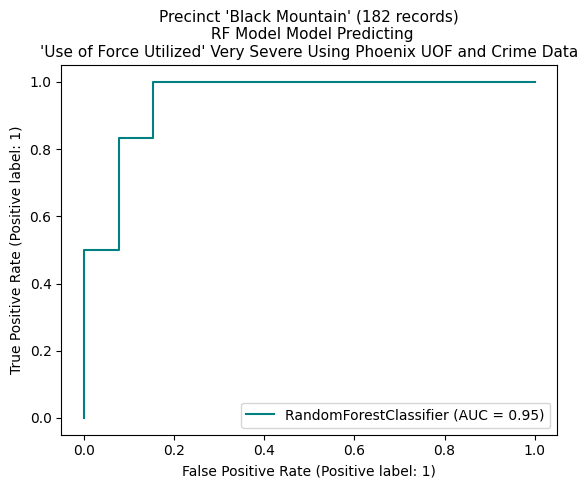

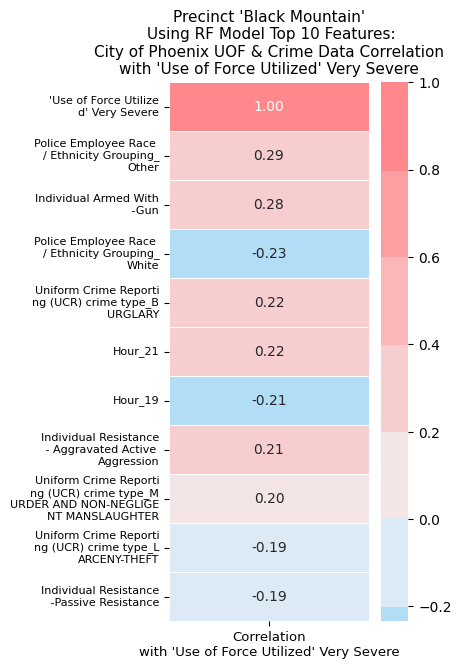


-----------------------------------------------------------
PRECINCT: CACTUS PARK
-----------------------------------------------------------

Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}

Accuracy: 0.771
Feature importances (Top 10):
------------------------------
- Uniform Crime Reporting (UCR) crime type_DRUG OFFENSE: 0.06
- Individual Resistance - Aggravated Active Aggression: 0.05
- Uniform Crime Reporting (UCR) crime type_AGGRAVATED ASSAULT: 0.05
- Uniform Crime Reporting (UCR) crime type_LARCENY-THEFT: 0.04
- Individual Armed With -Gun: 0.03
- Uniform Crime Reporting (UCR) crime type_BURGLARY: 0.03
- Individual Age Grouped_<20: 0.02
- Type of Location/Premise_SINGLE FAMILY HOUSE: 0.02
- Individual Resistance -Active Resistance: 0.02
- Day of Week_4-WEDNESSDAY: 0.02

Feature importances (Bottom 10):
------------------------------
- Police Beat_631 Beat: 0.0
- Police Beat_632 Beat: 0.0
- Police Beat_633 Beat: 0.0
- Police Beat_634 Beat: 

<Figure size 700x600 with 0 Axes>

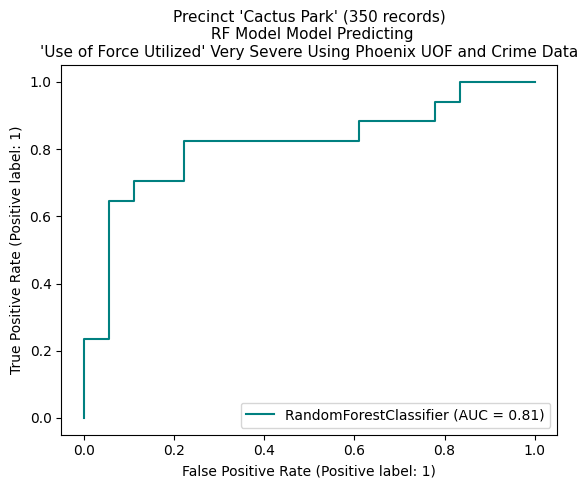

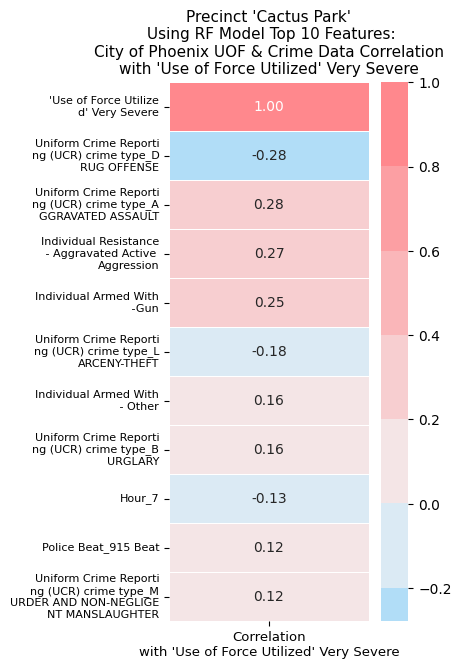


-----------------------------------------------------------
PRECINCT: CENTRAL CITY
-----------------------------------------------------------

Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}

Accuracy: 0.833
Feature importances (Top 10):
------------------------------
- Police Beat_514 Beat: 0.06
- Uniform Crime Reporting (UCR) crime type_BURGLARY: 0.04
- Police Beat_512 Beat: 0.03
- Uniform Crime Reporting (UCR) crime type_AGGRAVATED ASSAULT: 0.03
- Police Employee Race / Ethnicity Grouping_Hispanic: 0.03
- Uniform Crime Reporting (UCR) crime type_MURDER AND NON-NEGLIGENT MANSLAUGHTER: 0.02
- Individual Resistance -Active Aggression: 0.02
- Uniform Crime Reporting (UCR) crime type_MOTOR VEHICLE THEFT: 0.02
- Individual Resistance -Passive Resistance: 0.02
- Individual Resistance -Active Resistance: 0.02

Feature importances (Bottom 10):
------------------------------
- Police Beat_735 Beat: 0.0
- Police Beat_736 Beat: 0.0
- Police Beat_811 Beat

<Figure size 700x600 with 0 Axes>

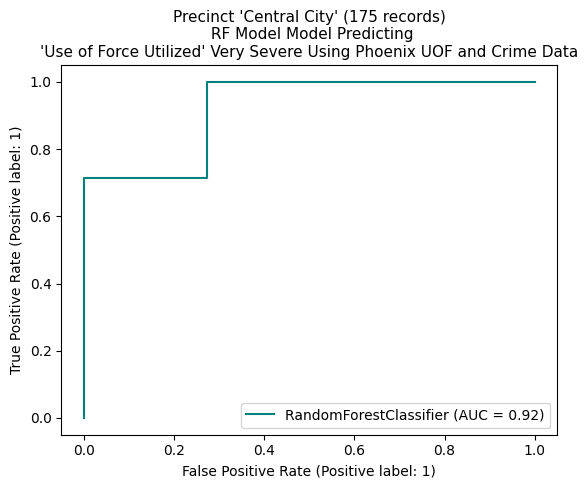

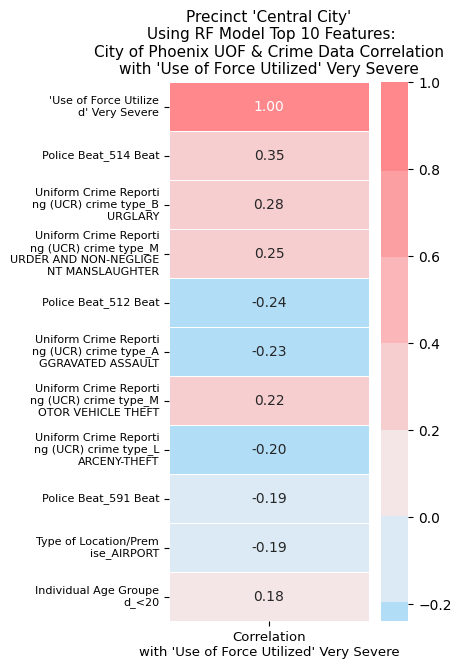


-----------------------------------------------------------
PRECINCT: DESERT HORIZON
-----------------------------------------------------------

Best Hyperparameters: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 5}

Accuracy: 0.833
Feature importances (Top 10):
------------------------------
- Police Beat_622 Beat: 0.04
- Individual Resistance -Active Resistance: 0.03
- Uniform Crime Reporting (UCR) crime type_DRUG OFFENSE: 0.03
- Individual Armed With -Gun: 0.03
- Individual Resistance -Verbal Non Compliance: 0.02
- Type of Location/Premise_SINGLE FAMILY HOUSE: 0.02
- Uniform Crime Reporting (UCR) crime type_AGGRAVATED ASSAULT: 0.02
- Individual Armed With - No Weapon: 0.02
- Hour_3: 0.02
- Individual Age Grouped_20s: 0.02

Feature importances (Bottom 10):
------------------------------
- Police Beat_811 Beat: 0.0
- Police Beat_812 Beat: 0.0
- Police Beat_813 Beat: 0.0
- Police Beat_814 Beat: 0.0
- Police Beat_815 Beat: 0.0
- Police Beat_821 Beat: 0.0
- Police Beat_

<Figure size 700x600 with 0 Axes>

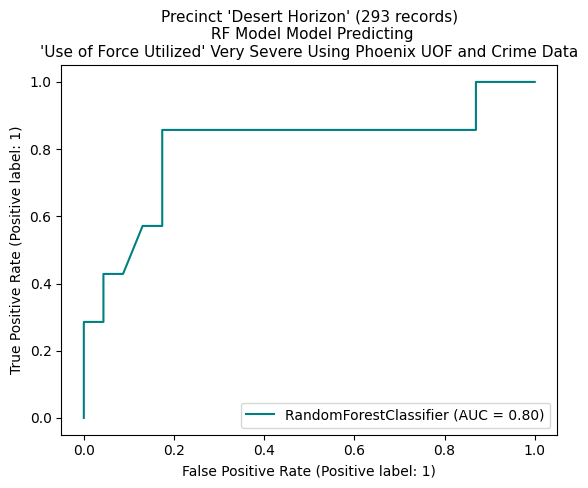

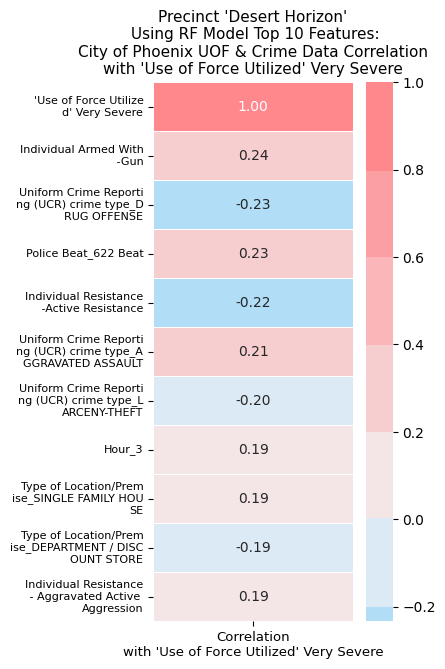


-----------------------------------------------------------
PRECINCT: MARYVALE-ESTRELLA
-----------------------------------------------------------

Best Hyperparameters: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2}

Accuracy: 0.531
Feature importances (Top 10):
------------------------------
- Uniform Crime Reporting (UCR) crime type_DRUG OFFENSE: 0.05
- Individual Resistance -Verbal Non Compliance: 0.03
- Individual Resistance -Active Aggression: 0.02
- Uniform Crime Reporting (UCR) crime type_AGGRAVATED ASSAULT: 0.02
- Police Employee Race / Ethnicity Grouping_Hispanic: 0.02
- Police Employee Race / Ethnicity Grouping_White: 0.02
- Individual Resistance -Passive Resistance: 0.02
- Individual Resistance -Active Resistance: 0.02
- Uniform Crime Reporting (UCR) crime type_ROBBERY: 0.02
- Individual Resistance -Psychological Intimidation: 0.02

Feature importances (Bottom 10):
------------------------------
- Police Beat_923 Beat: 0.0
- Police Beat_924 Beat: 0.0
- P

<Figure size 700x600 with 0 Axes>

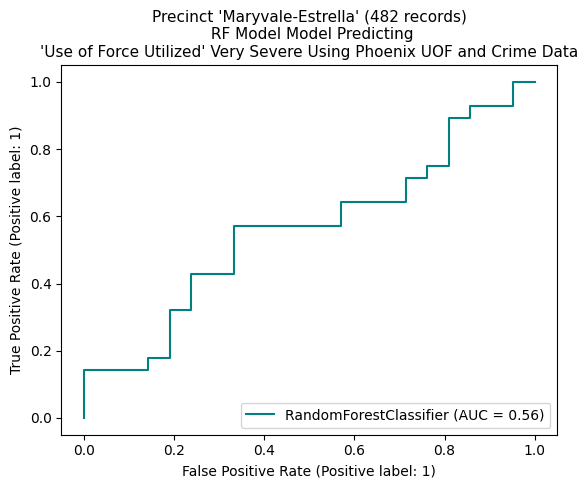

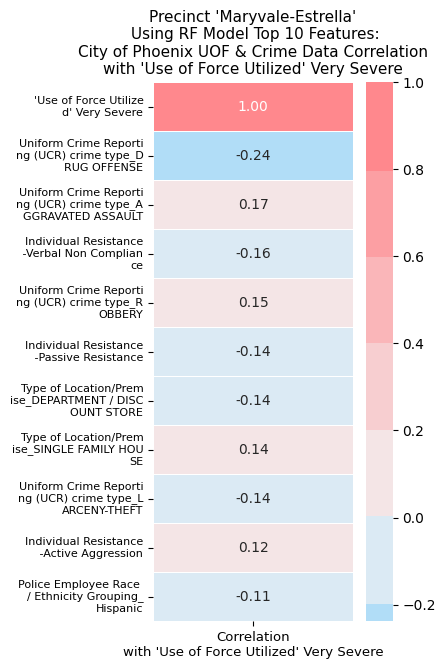


-----------------------------------------------------------
PRECINCT: MOUNTAIN VIEW
-----------------------------------------------------------

Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}

Accuracy: 0.653
Feature importances (Top 10):
------------------------------
- Individual Resistance -Active Resistance: 0.05
- Uniform Crime Reporting (UCR) crime type_DRUG OFFENSE: 0.05
- Individual Armed With -Gun: 0.05
- Uniform Crime Reporting (UCR) crime type_MOTOR VEHICLE THEFT: 0.03
- Uniform Crime Reporting (UCR) crime type_AGGRAVATED ASSAULT: 0.03
- Individual Resistance - Aggravated Active Aggression: 0.02
- Individual Resistance -Active Aggression: 0.02
- Individual Resistance -Passive Resistance: 0.02
- Individual Resistance -Psychological Intimidation: 0.02
- Day of Week_4-WEDNESSDAY: 0.02

Feature importances (Bottom 10):
------------------------------
- Police Beat_623 Beat: 0.0
- Police Beat_624 Beat: 0.0
- Police Beat_625 Beat: 0.0
- Pol

<Figure size 700x600 with 0 Axes>

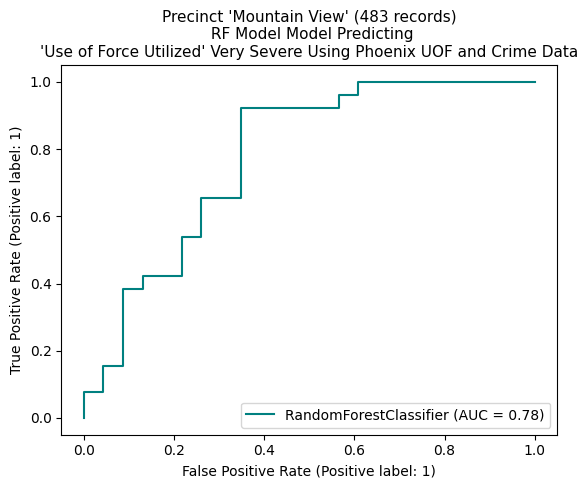

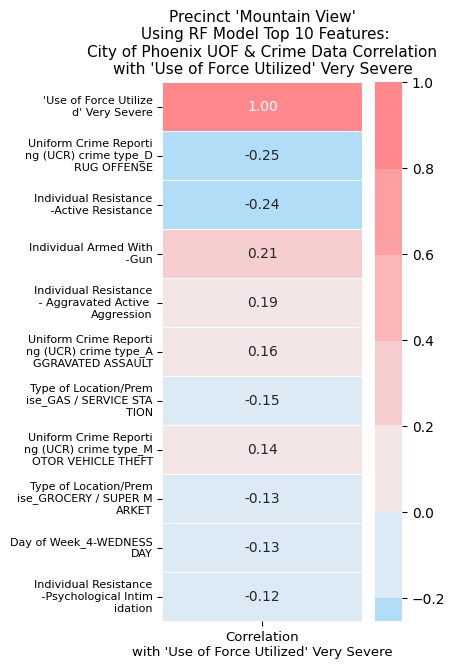


-----------------------------------------------------------
PRECINCT: SOUTH MOUNTAIN
-----------------------------------------------------------

Best Hyperparameters: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 5}

Accuracy: 0.735
Feature importances (Top 10):
------------------------------
- Individual Resistance - Aggravated Active Aggression: 0.05
- Individual Armed With -Gun: 0.05
- Uniform Crime Reporting (UCR) crime type_AGGRAVATED ASSAULT: 0.05
- Type of Location/Premise_SINGLE FAMILY HOUSE: 0.03
- Uniform Crime Reporting (UCR) crime type_DRUG OFFENSE: 0.03
- Uniform Crime Reporting (UCR) crime type_LARCENY-THEFT: 0.02
- Type of Location/Premise_STREET / ROADWAY / ALLEY / SIDEWALK: 0.02
- Individual Resistance -Passive Resistance: 0.02
- Individual Resistance -Active Resistance: 0.02
- Individual Resistance -Active Aggression: 0.02

Feature importances (Bottom 10):
------------------------------
- Police Beat_725 Beat: 0.0
- Police Beat_726 Beat: 0.0
- Police

<Figure size 700x600 with 0 Axes>

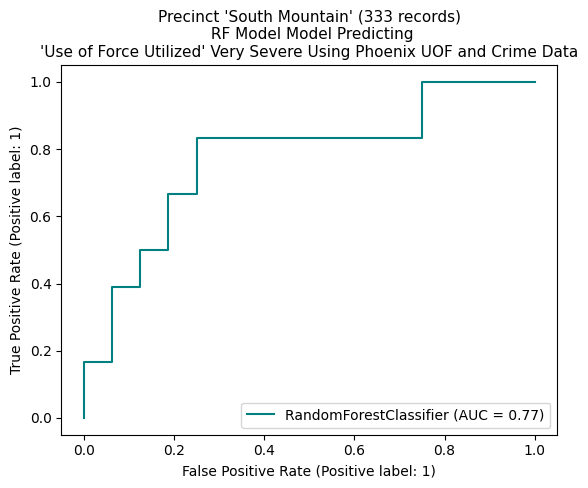

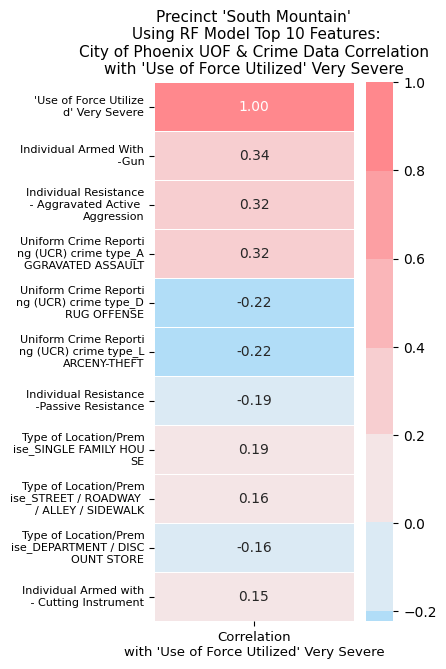

In [14]:
precinct_model_aucs = {}

for the_precinct in precincts_in_data:

  # set X and y
  precinct_name = the_precinct.split(" Precinct")[0]
  df_by_precinct = uof_crime_encoded[uof_crime_encoded['Police Precinct'] == the_precinct]

  print("\n-----------------------------------------------------------")
  print(f"PRECINCT: {precinct_name.upper()}")
  print("-----------------------------------------------------------\n")

  X = df_by_precinct.drop(columns=[aggregate_col_name]).iloc[:, 1:]
  y = df_by_precinct[aggregate_col_name]

  # Split the data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

  param_grid = {
      'max_depth': [5, 10, 15],  # Adjust as needed
      'min_samples_split': [2, 5, 10],  # Adjust as needed
      'min_samples_leaf': [1, 5, 10]  # Adjust as needed
  }

  # Initialize Random Forest classifier
  rf_classifier = RandomForestClassifier()

  # Initialize GridSearchCV
  grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')

  # Perform grid search
  grid_search.fit(X_train, y_train)

  # Get the best parameters
  best_params = grid_search.best_params_
  print("Best Hyperparameters:", best_params)

  # Get the best model
  best_rf_classifier = grid_search.best_estimator_

  # Make predictions on the test data using the best model
  y_pred = best_rf_classifier.predict(X_test)

  # Evaluate the model's performance
  accuracy = accuracy_score(y_test, y_pred)
  print("\nAccuracy:", round(accuracy, 3))

  plt.figure(figsize=(7, 6), dpi = 100)

  RocCurveDisplay.from_estimator(best_rf_classifier, X_test, y_test, color = 'teal')

  # Get the AUC score and set the precinct dict value to it
  y_pred_proba = best_rf_classifier.predict_proba(X_test)[:, 1]
  auc_score = round(roc_auc_score(y_test, y_pred_proba), 2)
  precinct_model_aucs[the_precinct] = auc_score

  plt.title(f"Precinct '{precinct_name}' ({len(X)} records)\n RF Model Model Predicting\n{aggregate_col_name} Using Phoenix UOF and Crime Data",
            fontsize = 11)

  # Save the plot to file
  plt.savefig(f'Plots/Results Plots/{precinct_name.replace(" ", "_").lower()}_rnf_classifier_roc_auc.jpeg', dpi = 350)

  # Get feature importances
  feature_importances = pd.Series(best_rf_classifier.feature_importances_, index=X.columns)

  # Sort feature importances in descending order
  sorted_feature_importances = feature_importances.sort_values(ascending=False)

  n_top_features = 10
  if n_top_features > len(sorted_feature_importances):
    n_top_features =  len(sorted_feature_importances)


  # Print feature importances
  print(f"Feature importances (Top {n_top_features}):\n------------------------------")
  #print(sorted_feature_importances.head(n_top_features))

  top_features_importances_list = list(sorted_feature_importances.head(n_top_features).index)
  for index_item, val in zip(top_features_importances_list,
                            list(sorted_feature_importances.head(n_top_features))):
    print(f"- {index_item}: {np.round(val, 2)}")

  print(f"\nFeature importances (Bottom {n_top_features}):\n------------------------------")

  bottom_features_importances_list = list(sorted_feature_importances.tail(n_top_features).index)
  for index_item, val in zip(bottom_features_importances_list,
                            list(sorted_feature_importances.tail(n_top_features))):
    print(f"- {index_item}: {np.round(val, 2)}")


  # Reorder columns with 'aggregate_col_name' at the front
  df_by_precinct = df_by_precinct[[aggregate_col_name] + [col for col in df_by_precinct.columns if col not in ('Police Precinct', aggregate_col_name)]]

  # this evaluates the correlations with Severe UOF
  evaluate_top_props(list(sorted_feature_importances.head(n_top_features).index))

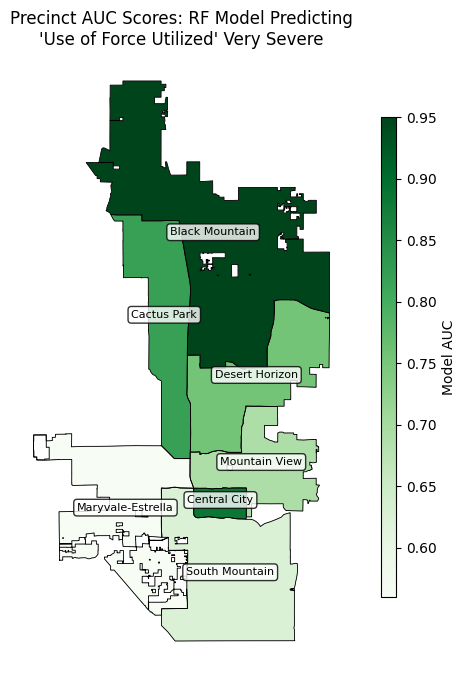

In [15]:
# Link and plot Precinct AUCs ----------------------------------

precinct_gdf = gpd.read_file("../location demographic shapefiles/precinct_map.geojson")
precinct_gdf['NAME'] = precinct_gdf['NAME'].apply(lambda x: x.split(" Precinct")[0] if 'Maryvale/Estrella' not in x else 'Maryvale-Estrella')
precinct_gdf['NAME'] = precinct_gdf['NAME'].apply(lambda x: x.split(" Precinct")[0])
precinct_gdf = precinct_gdf.drop(precinct_gdf[precinct_gdf['NAME'] == 'Sky Harbor International Airport'].index)
precinct_gdf = precinct_gdf.reset_index(drop=True)

precinct_gdf['model_auc'] = None  # Initialize the column with None values

for i, precinct_name in enumerate(precinct_gdf['NAME']):
    if precinct_name in precinct_model_aucs:
      precinct_gdf.at[i, 'model_auc'] = precinct_model_aucs[precinct_name]

# Prepare the Plot ------
the_cmap = 'Greens'
vmin = min(precinct_gdf["model_auc"]); vmax = max(precinct_gdf["model_auc"])

fig, ax = plt.subplots(figsize=(5, 8), dpi=100)

precinct_gdf.plot(column = "model_auc",
                  cmap = the_cmap,
                  legend = False,
                  ax = ax)
ax.set_title(f"Precinct AUC Scores: RF Model Predicting\n{aggregate_col_name}")
precinct_gdf.boundary.plot(facecolor='none', color="grey", ax = ax, linewidth=0.25)
ax.axis('off')
plt.subplots_adjust(left=-0.1)

# Plot precinct names at centroids with a highlight behind the labels
for idx, row in precinct_gdf.iterrows():
    plt.annotate(text=row['NAME'], xy=row.geometry.centroid.coords[0], ha='center', fontsize=8,
                 bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='black', alpha=0.8))

# Create color bar
norm = Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=the_cmap, norm=norm)
sm.set_array([])  # Empty array since we don't use it, but required for ColorbarBase
cbar = ColorbarBase(ax=fig.add_axes([0.8, 0.2, 0.03, 0.6]), cmap=the_cmap, norm=norm)
cbar.set_label('Model AUC')

precinct_gdf.boundary.plot(ax=ax, facecolor='none', color="black", linewidth=0.6)

# Save the plot to file
plt.savefig(f'Plots/Results Plots/all_precincts_rnf_classifier_roc_auc.jpeg', dpi = 350)

plt.show()

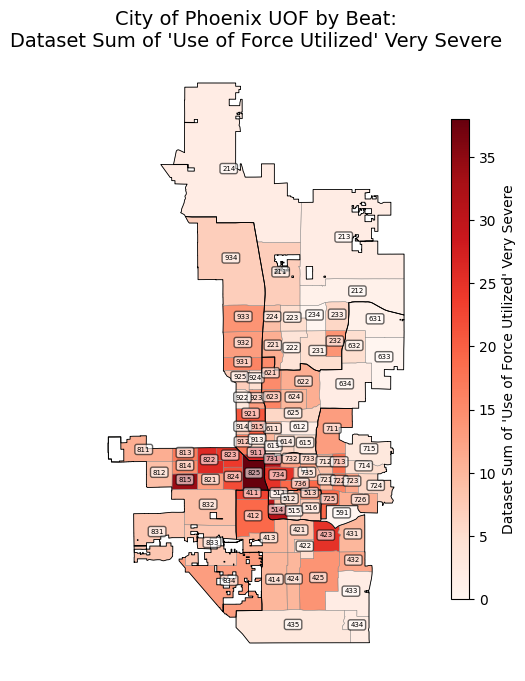

In [16]:
# Link and plot Beat UOF Sums ----------------------------------

beat_gdf = gpd.read_file("../location demographic shapefiles/beat_map.geojson")
beat_severity = uof_crime_df.groupby('Police Beat')[aggregate_col_name].sum().sort_values(ascending=False).rename_axis('BEAT').reset_index()

beat_severity["BEAT"] = beat_severity["BEAT"].apply(lambda x: x.split(" Beat")[0])
beat_severity = beat_severity[beat_severity['BEAT'].str.len() <= 3]
beat_severity["BEAT"] = beat_severity["BEAT"].astype(int)

beat_gdf = beat_gdf.merge(beat_severity, how='left', on='BEAT')

# Prepare the Plot ------
the_cmap = 'Reds'
vmin = min(beat_severity[aggregate_col_name]); vmax = max(beat_severity[aggregate_col_name])

fig, ax = plt.subplots(figsize=(6, 8), dpi=100)

beat_gdf.plot(column = aggregate_col_name,
                  cmap = the_cmap,
                  legend = False,
                  ax = ax)
ax.set_title(f"City of Phoenix UOF by Beat:\nDataset Sum of {aggregate_col_name}", fontsize = 14)
beat_gdf.boundary.plot(facecolor='none', color="grey", ax = ax, linewidth=0.25)
ax.axis('off')
plt.subplots_adjust(left=-0.05)

# Plot precinct names at centroids with a highlight behind the labels
for idx, row in beat_gdf.iterrows():
    plt.annotate(text=row['BEAT'], xy=row.geometry.centroid.coords[0], ha='center', fontsize=5,
                 bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='black', alpha=0.6))

# Create color bar
norm = Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=the_cmap, norm=norm)
sm.set_array([])  # Empty array since we don't use it, but required for ColorbarBase
cbar = ColorbarBase(ax=fig.add_axes([0.75, 0.2, 0.03, 0.6]), cmap=the_cmap, norm=norm)
cbar.set_label(f"Dataset Sum of {aggregate_col_name}")

precinct_gdf.boundary.plot(ax=ax, facecolor='none', color="black", linewidth=0.6)

# Save the plot to file
plt.savefig(f'Plots/Results Plots/all_beats_uof_sum.jpeg', dpi = 350)

plt.show()